# Восстановление золота из руды

Необходимо подготовить прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. Испольем данные с параметрами добычи и очистки. 

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

Нам необходимо:

1. Подготовить данные;
2. Провести исследовательский анализ данных;
3. Построить и обучить модель.

## Вводная информация по технологическому процессу 

**Стадии получения золота из горной руды**

1. *Флотация*

Во флотационную установку подаётся смесь золотосодержащей руды. После обогащения получается черновой концентрат и «отвальные хвосты», то есть остатки продукта с низкой концентрацией ценных металлов.
На стабильность этого процесса влияет непостоянное и неоптимальное физико-химическое состояние флотационной пульпы (смеси твёрдых частиц и жидкости).


2. *Очистка*

Черновой концентрат проходит две очистки. На выходе получается финальный концентрат и новые отвальные хвосты.

**Технологический процесс**

- Rougher feed — исходное сырье
- Rougher additions (или reagent additions) — флотационные реагенты: Xanthate, Sulphate, Depressant
- Xanthate **— ксантогенат (промотер, или активатор флотации);
- Sulphate — сульфат (на данном производстве сульфид натрия);
- Depressant — депрессант (силикат натрия).
- Rougher process (англ. «грубый процесс») — флотация
- Rougher tails — отвальные хвосты
- Float banks — флотационная установка
- Cleaner process — очистка
- Rougher Au — черновой концентрат золота
- Final Au — финальный концентрат золота

**Параметры этапов**

- air amount — объём воздуха
- fluid levels — уровень жидкости
- feed size — размер гранул сырья
- feed rate — скорость подачи


Согласно предоставленной информации, данные в выгрузке представленны в следующем виде:

**Вид признака**
- общее название признака [этап].[тип_параметра].[название_параметра]

**Возможные значения для блока [этап]:**
- rougher — флотация
- primary_cleaner — первичная очистка
- secondary_cleaner — вторичная очистка
- final — финальные характеристики

**Возможные значения для блока [тип_параметра]:**
- input — параметры сырья
- output — параметры продукта
- state — параметры, характеризующие текущее состояние этапа
- calculation — расчётные характеристики

## Подготовка данных

In [1]:
#импортируем все необходимые библиотеки, которые нам понадобятся при дальнейшем ислледовании

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import RandomState
from scipy import stats as st
from numpy.random import RandomState
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.dummy import DummyRegressor

### 1.1. Выгрузка датасетов

Произведем выгрузку представленных датасетов для последующего анализа и построения моделей.

In [2]:
try:
    
    df_train = pd.read_csv('gold_recovery_train_new.csv', index_col = 'date')
    df_test = pd.read_csv('gold_recovery_test_new.csv', index_col = 'date')
    df_full = pd.read_csv('gold_recovery_full_new.csv', index_col = 'date')

except:
    #
    df_train = pd.read_csv('/datasets/gold_recovery_train_new.csv', index_col = 'date')
    df_test = pd.read_csv('/datasets/gold_recovery_test_new.csv', index_col = 'date')
    df_full = pd.read_csv('/datasets/gold_recovery_full_new.csv', index_col = 'date')

Ознакомимся с предоставленными датасетами.

1. Обучающая выборка

In [3]:
df_train.head()

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,
2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629232,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,123.819808,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,122.270188,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,117.988169,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


2. Тестовая выборка.

In [4]:
df_test.head()

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,
2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,-500.704369,...,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,-499.240168,...,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,-502.151509,...,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,-498.355873,...,12.033091,-498.350935,8.074946,-499.474407,7.897085,-500.868509,4.931400,-499.963623,24.948919,-498.709987
2016-09-01 04:59:59,199.099327,10.682530,7.530000,0.805575,1401.268123,-500.808305,1398.128818,-499.504543,1402.172226,-500.810606,...,12.025367,-500.786497,8.054678,-500.397500,8.107890,-509.526725,4.957674,-500.360026,25.003331,-500.856333


3. Полный датасет.

In [5]:
df_full.head()

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,
2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629232,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,123.819808,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,122.270188,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,117.988169,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


Рассмотрим более подробно предоставленные данные.

In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14149 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 86 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   final.output.concentrate_ag                         14148 non-null  float64
 1   final.output.concentrate_pb                         14148 non-null  float64
 2   final.output.concentrate_sol                        13938 non-null  float64
 3   final.output.concentrate_au                         14149 non-null  float64
 4   final.output.recovery                               14149 non-null  float64
 5   final.output.tail_ag                                14149 non-null  float64
 6   final.output.tail_pb                                14049 non-null  float64
 7   final.output.tail_sol                               14144 non-null  float64
 8   final.output.tail_au                             

In [7]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5290 entries, 2016-09-01 00:59:59 to 2017-12-31 23:59:59
Data columns (total 52 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   primary_cleaner.input.sulfate               5286 non-null   float64
 1   primary_cleaner.input.depressant            5285 non-null   float64
 2   primary_cleaner.input.feed_size             5290 non-null   float64
 3   primary_cleaner.input.xanthate              5286 non-null   float64
 4   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64
 5   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64
 6   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64
 7   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64
 8   primary_cleaner.state.floatbank8_c_air      5290 non-null   float64
 9   primary_cleaner.state.floatbank8_c_level    5290 non-null

In [8]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19439 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 86 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   final.output.concentrate_ag                         19438 non-null  float64
 1   final.output.concentrate_pb                         19438 non-null  float64
 2   final.output.concentrate_sol                        19228 non-null  float64
 3   final.output.concentrate_au                         19439 non-null  float64
 4   final.output.recovery                               19439 non-null  float64
 5   final.output.tail_ag                                19438 non-null  float64
 6   final.output.tail_pb                                19338 non-null  float64
 7   final.output.tail_sol                               19433 non-null  float64
 8   final.output.tail_au                             

**Вывод 1.1**

На основании рассмотренных данных видно:

1) Количество признаков (столбцов) в датасетах df_train и df_full 87. При этом в тестовой выборке количество признаков 53. Согласно вводным данным, в тестовой выборке признаков меньше и отсутствует целевой признак.

2) Во всех датасетах имеются пропущенные значения. Это может быть связано с 2-мя факторами:

- Некоторые параметры недоступны, потому что замеряются и/или рассчитываются значительно позже. Из-за этого в тестовой выборке отсутствуют некоторые признаки, которые могут быть в обучающей. Также в тестовом наборе нет целевых признаков.

- Ошибки при выгрузке датасета или неполные данные.

### 1.2. Проверка расчета эффективности обогащения золота

На следующем этапе проверим корректность формулы вычисления эффективности обогащения золота. Формула расчета эф-ти обогащения золота выглядит следующим образом

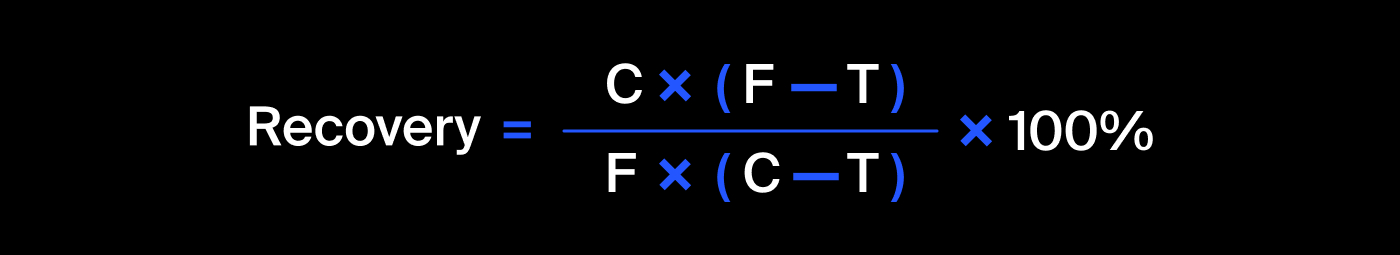

где:

C — доля золота в концентрате после флотации/очистки;

F — доля золота в сырье/концентрате до флотации/очистки;

T — доля золота в отвальных хвостах после флотации/очистки.

Следовательно, для расчета нам вначале потребуется расчет доли золота в  концентрате и хвостах в признаке ***rougher.output.recovery.*** (флотация.выход.востановление), то есть эффективность обогащения после флотации (первая стадия).

Для этого рассмотрим тренировочную выборку, поскольку:

1) В полном исходном датасете отсутствует целевой признак.

2) В обязательном порядке мы будем производить предобработку в тестовой выборке, поэтому надо понять, что с ней не так.

Выделим из тренировочной выборки для удобства необходимые признаки, для расчета эф-ти обогащения при флотации.

In [9]:
df_train_rougher = df_train[['rougher.input.feed_ag','rougher.input.feed_pb','rougher.input.feed_sol',
                            'rougher.input.feed_au','rougher.output.concentrate_ag','rougher.output.concentrate_pb',
                            'rougher.output.concentrate_sol','rougher.output.concentrate_au','rougher.output.recovery',
                            'rougher.output.tail_ag', 'rougher.output.tail_pb','rougher.output.tail_sol',
                            'rougher.output.tail_au']]
            
df_train_rougher.head()        

,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_sol,rougher.input.feed_au,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au
date,,,,,,,,,,,,,
2016-01-15 00:00:00,6.100378,2.284912,36.808594,6.486150,11.500771,7.101074,28.029297,19.793808,87.107763,5.008018,0.508728,19.154297,1.170244
2016-01-15 01:00:00,6.161113,2.266033,35.753385,6.478583,11.615865,7.278807,28.067063,20.050975,86.843261,4.955378,0.536689,18.965234,1.184827
2016-01-15 02:00:00,6.116455,2.159622,35.971630,6.362222,11.695753,7.216833,27.454037,19.737170,86.842308,4.843460,0.546416,18.808533,1.162562
2016-01-15 03:00:00,6.043309,2.037807,36.862241,6.118189,11.915047,7.175616,27.341277,19.320810,87.226430,4.655288,0.542525,19.330200,1.079755
2016-01-15 04:00:00,6.060915,1.786875,34.347666,5.663707,12.411054,7.240205,27.041023,19.216101,86.688794,4.552800,0.515438,19.267422,1.012642


In [10]:
#приступим к расчету коэффициента
#в тренировочной выборке создадим столбец "rough_recov_calc"
df_train['rough_recov_calc'] = 100 * (df_train['rougher.output.concentrate_au']*\
                                      (df_train['rougher.input.feed_au']-df_train['rougher.output.tail_au']))/\
                                      (df_train['rougher.input.feed_au']*\
                                      (df_train['rougher.output.concentrate_au']-df_train['rougher.output.tail_au']))

#для информации выведем первые 10 значений расчитанного и предоставленного коэф.востановления
#после флотации
df_train[['rough_recov_calc', 'rougher.output.recovery']].head(10) 

,rough_recov_calc,rougher.output.recovery
date,,
2016-01-15 00:00:00,87.107763,87.107763
2016-01-15 01:00:00,86.843261,86.843261
2016-01-15 02:00:00,86.842308,86.842308
2016-01-15 03:00:00,87.226430,87.226430
2016-01-15 04:00:00,86.688794,86.688794
2016-01-15 05:00:00,88.156912,88.156912
2016-01-15 06:00:00,88.168065,88.168065
2016-01-15 07:00:00,87.668336,87.668336
2016-01-15 08:00:00,87.035862,87.035862


Расчитаем метриру МАЕ для расчитанного и предоставленного эффективности востановления после флотации в тренировочной выборке.

In [11]:
rough_recov_mae = mean_absolute_error(df_train['rougher.output.recovery'], df_train['rough_recov_calc'])
rough_recov_mae

1.1131451184435918e-14

**Вывод**

Значение среднего аболютного отколнения является незначительным. Следовательно, формула расчета эффективности востановления работает корректно, в том числе в ранее расчитанных данных в исходном датасете.

**Сравнение выборок.**

Как было отмечено ранее, количество признаков в тестовой выборке меньше, чем в тренировочной и полной.
Проверим, какие признаки отсутствуют в тестовой выборке.

In [12]:
df_train_columns = list(df_train.columns)
df_test_columns = list(df_test.columns)

absent_col_in_test = []

for i in range(len(df_train_columns)):
    if df_train_columns[i] not in df_test_columns:
        absent_col_in_test.append(df_train_columns[i])
        
absent_col_in_test

['final.output.concentrate_ag',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.concentrate_au',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'final.output.tail_au',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'primary_cleaner.output.tail_au',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.au_pb_ratio',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.concentrate_au',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_pb',
 'rougher.output.ta

In [13]:
len(absent_col_in_test)

35

Без учета rough_recov_calc (расчетной эффективности востановления, который мы ранее расчитали), в тестовой выборке отсутствуют 34 признака по:

- финальному выходу после очисток (доли в концентратах, хвостах, эффективности востановления);
- флотации (доли в концентратах, хвостах, эффективности востановления);
- первичному этапу очистки (доли в концентратах и хвостах);
- вторичному этапу очистки (доли в хвостах);
- концентрации веществ для проведения флотации.

**Вывод 1.2**

Следовательно, при дальнейшей подготовке модели предсказания, нам далее прийдется из тренировочной выборки исключить данные признаки.

<font color='blue'><b>Комментарий ревьюера: </b></font> ✔️\
<font color='green'> Верно!</font>

### 1.3. Предобработка данных

**Обучающая выборка**

Произведем предобработку данных тренировочной выборки.

Проверим наличие явных дубликатов.

In [14]:
df_train.duplicated().sum()

0

Явные дубликаты отсуствуют. Проверим количество пропусков в тренировочной выборке.

In [15]:
df_train.isna().sum().value_counts()

1       30
0       25
4        3
100      3
2        3
8        2
3        1
36       1
217      1
86       1
211      1
78       1
1605     1
436      1
46       1
428      1
286      1
32       1
5        1
29       1
21       1
20       1
144      1
15       1
10       1
6        1
22       1
dtype: int64

На основании полученных данных видно, что колличество пропусков незначительно. 

Дополнительно проверим максимальное количество пропусков и найдем столбец.

In [16]:
df_train.isna().sum().max()

1605

In [17]:
df_train.isna().sum().sort_values(ascending = False)

secondary_cleaner.output.tail_sol           1605
rougher.state.floatbank10_e_air              436
rougher.input.floatbank11_xanthate           428
primary_cleaner.output.concentrate_sol       286
secondary_cleaner.state.floatbank2_a_air     217
                                            ... 
rougher.output.tail_au                         0
rougher.state.floatbank10_d_air                0
rougher.state.floatbank10_d_level              0
rougher.state.floatbank10_e_level              0
rough_recov_calc                               0
Length: 87, dtype: int64

Проверим доли пропусков наибольших (топ-3 значений)

In [18]:
isna_ratio_1 = df_train['secondary_cleaner.output.tail_sol'].isna().sum()/14149
isna_ratio_1

0.11343557848611209

In [19]:
isna_ratio_2 = df_train['rougher.state.floatbank10_e_air'].isna().sum()/14149
isna_ratio_2

0.030814898579404906

In [20]:
isna_ratio_3 = df_train['rougher.input.floatbank11_xanthate'].isna().sum()/14149
isna_ratio_3

0.03024948759629656

Наибольший процент пропусков (11%) в столбце secondary_cleaner.output.tail_sol. Данный столбе обозначает отходы после 2-ого этапа очистки. Расшифровки по sol у нас в тех.документации нет, по этому у данного показателя могут быть несколько значений: solvent (растворитель), solid (твердое вещество). 

Проверим распределение данной величины.

<AxesSubplot:>

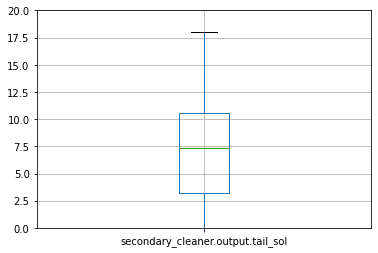

In [21]:
plt.ylim(0,20)
df_train.boxplot('secondary_cleaner.output.tail_sol')

Учитывая, что основной объем величин у secondary_cleaner.output.tail_sol находистся в пределах от 3 до 10,5 , заменим пропуск на медианное значение.

In [22]:
df_train['secondary_cleaner.output.tail_sol'] = df_train['secondary_cleaner.output.tail_sol'].fillna(df_train['secondary_cleaner.output.tail_sol'].median())
df_train['secondary_cleaner.output.tail_sol'].isna().sum()

0

Проверим наличие пропусков в целевых признаках на тренировочной выборке.

Учитывая, что в остальных объектах датасета пропуски составляют менее 3%, удалим их.

In [23]:
df_train = df_train.dropna()

Проверим наличие пропусков в целевых признаках на тренировочной выборке.

In [24]:
df_train.loc[df_train.loc[:,'rougher.output.recovery'] == 0]['rougher.output.recovery'].count()

206

In [25]:
df_train.loc[df_train.loc[:,'final.output.recovery'] == 0]['final.output.recovery'].count()

31

**Тестовая выборка**

Приступим к предобработке данных на тестовой выборке.

Проверим наличие явных дубликатов.

In [26]:
df_test.duplicated().sum()

0

Неявные дубликаты отсутствуют. Проверим количество пропусков.

In [27]:
df_test.isna().sum()

primary_cleaner.input.sulfate                  4
primary_cleaner.input.depressant               5
primary_cleaner.input.feed_size                0
primary_cleaner.input.xanthate                 4
primary_cleaner.state.floatbank8_a_air         0
primary_cleaner.state.floatbank8_a_level       0
primary_cleaner.state.floatbank8_b_air         0
primary_cleaner.state.floatbank8_b_level       0
primary_cleaner.state.floatbank8_c_air         0
primary_cleaner.state.floatbank8_c_level       0
primary_cleaner.state.floatbank8_d_air         0
primary_cleaner.state.floatbank8_d_level       0
rougher.input.feed_ag                          0
rougher.input.feed_pb                          0
rougher.input.feed_rate                        3
rougher.input.feed_size                        1
rougher.input.feed_sol                        21
rougher.input.feed_au                          0
rougher.input.floatbank10_sulfate              5
rougher.input.floatbank10_xanthate             0
rougher.input.floatb

In [28]:
df_test.isna().sum().value_counts()

0     40
3      2
4      2
5      2
1      1
2      1
8      1
9      1
21     1
25     1
dtype: int64

In [29]:
isna_ratio_test = df_test['rougher.input.floatbank11_xanthate'].isna().sum()/5290
isna_ratio_test

0.004725897920604915

Так как количество пропусков у в тестовой выборке незначительно, то избавимся от пропущенных значений.

In [30]:
df_test = df_test.dropna()
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5229 entries, 2016-09-01 00:59:59 to 2017-12-31 23:59:59
Data columns (total 52 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   primary_cleaner.input.sulfate               5229 non-null   float64
 1   primary_cleaner.input.depressant            5229 non-null   float64
 2   primary_cleaner.input.feed_size             5229 non-null   float64
 3   primary_cleaner.input.xanthate              5229 non-null   float64
 4   primary_cleaner.state.floatbank8_a_air      5229 non-null   float64
 5   primary_cleaner.state.floatbank8_a_level    5229 non-null   float64
 6   primary_cleaner.state.floatbank8_b_air      5229 non-null   float64
 7   primary_cleaner.state.floatbank8_b_level    5229 non-null   float64
 8   primary_cleaner.state.floatbank8_c_air      5229 non-null   float64
 9   primary_cleaner.state.floatbank8_c_level    5229 non-null

**Вывод 1.3**

Данные предобработаны.

## Анализ данных

Рассмотрим процесс востановления золота из руды более подробно.

### 2.1. Изменение концентрации элементов в процессе очистки

Рассмотрим изменение концентрации элементов Au, Ag, Pb в процессе очистки.

Выделим данные признаки в отдельный датасет (df_concentration).

In [31]:
df_concentration = df_train[['rougher.input.feed_ag','rougher.input.feed_pb','rougher.input.feed_au',
                            'rougher.output.concentrate_ag','rougher.output.concentrate_pb','rougher.output.concentrate_au',
                            'primary_cleaner.output.concentrate_ag','primary_cleaner.output.concentrate_pb','primary_cleaner.output.concentrate_au',
                            'final.output.concentrate_ag','final.output.concentrate_pb','final.output.concentrate_au']]
df_concentration.head()

,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_au,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_au,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_au,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_au
date,,,,,,,,,,,,
2016-01-15 00:00:00,6.100378,2.284912,6.486150,11.500771,7.101074,19.793808,8.547551,10.389648,34.174427,6.055403,9.889648,42.192020
2016-01-15 01:00:00,6.161113,2.266033,6.478583,11.615865,7.278807,20.050975,8.558743,10.497069,34.118526,6.029369,9.968944,42.701629
2016-01-15 02:00:00,6.116455,2.159622,6.362222,11.695753,7.216833,19.737170,8.603505,10.354494,33.969464,6.055926,10.213995,42.657501
2016-01-15 03:00:00,6.043309,2.037807,6.118189,11.915047,7.175616,19.320810,7.221879,8.496563,28.260743,6.047977,9.977019,42.689819
2016-01-15 04:00:00,6.060915,1.786875,5.663707,12.411054,7.240205,19.216101,9.089428,9.986786,33.044932,6.148599,10.142511,42.774141


In [32]:
df_concentration.describe()

,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_au,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_au,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_au,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_au
count,12245.000000,12245.000000,12245.000000,12245.000000,12245.000000,12245.000000,12245.000000,12245.000000,12245.000000,12245.000000,12245.000000,12245.000000
mean,8.608579,3.557660,7.940149,11.813971,7.737378,19.628357,8.275255,9.694681,32.396620,5.084075,10.217381,44.235977
std,1.896136,1.066716,1.829443,2.587167,1.762359,3.495520,1.932572,2.597600,5.438798,1.324223,1.574890,4.137740
min,0.010000,0.010000,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7.143893,2.811830,6.669860,10.509719,6.896294,18.577989,7.172502,8.444144,30.787406,4.173854,9.342016,43.344487
50%,8.148057,3.459495,7.688152,11.729089,7.772689,20.045231,8.261417,9.996089,33.099856,4.916966,10.385437,44.898711
75%,10.000623,4.257870,9.066976,13.342284,8.650494,21.478276,9.545107,11.356572,35.202943,5.777093,11.226519,46.166541
max,14.596026,7.142594,13.126043,21.725695,12.797765,28.146838,15.005789,17.081278,45.933934,16.001945,17.031899,51.571885


Из таблицы видно, что концентрация элементов в технологическом процессе растет.
Для дальнейшей оценкии изменения концентарции для оценки будем брать среднее значение из признаков.

Для визуализации динамики изменения концентрации, создажим функцию, которая будет строить график динамики на основаниии следующийх параментров:
- Датафрейм с концентрациями на каждом этапе
- Наименования колонок из датафрейма для конкретного элемента
- Указание элемента.

In [33]:
def build_plot(df, columns, element): #функция для построения графика динамики изменения концентрации
    mean_list = [] #создаем пустой список
    mean_list.append(df.mean()) #добавляем в него среднее значение для этапа востановления
    #cоздаем датафрейм с указанием этапов процесса и средних значений концентрации
    #и транспонируем его, чтобы было удобнее строить график
    new_df = pd.DataFrame(data = mean_list, columns = columns).transpose() 
    plot = new_df.plot(style='o--', figsize=(15, 6), grid=True)
    plt.title(f'Динамика изменения концентрации {element}')
    plt.xlabel('Стадии востановления рубы')
    plt.ylabel('Концентрация')
    return plot

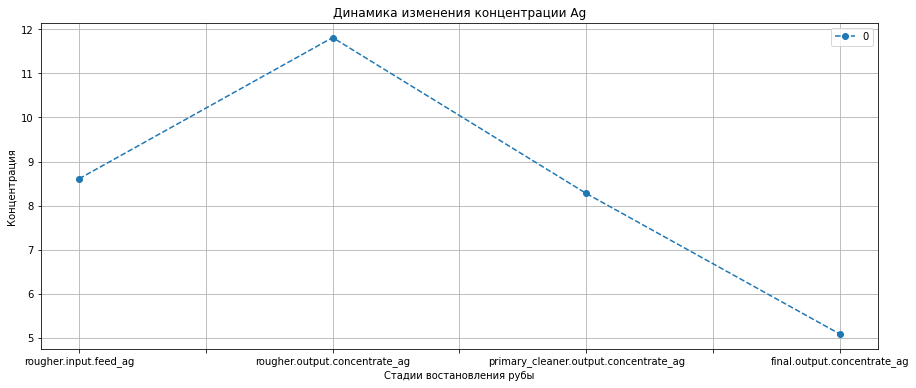

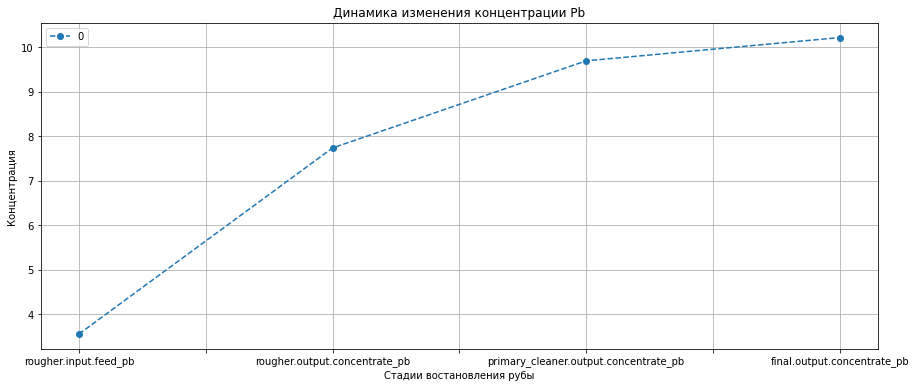

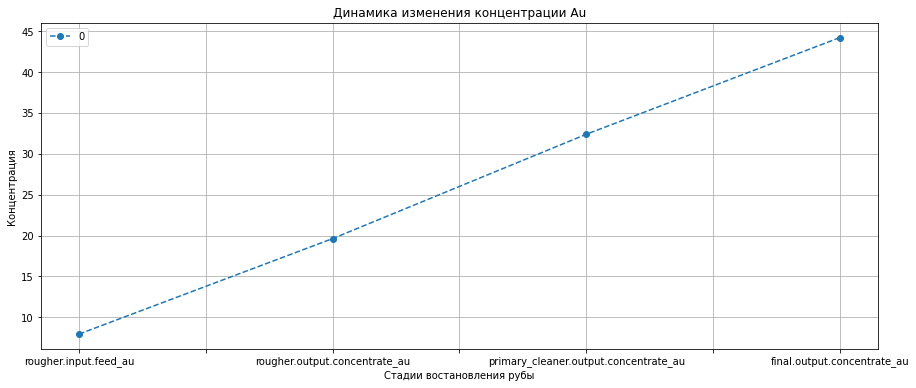

In [34]:
ag_columns = ['rougher.input.feed_ag','rougher.output.concentrate_ag','primary_cleaner.output.concentrate_ag', 'final.output.concentrate_ag']
pb_columns = ['rougher.input.feed_pb','rougher.output.concentrate_pb','primary_cleaner.output.concentrate_pb', 'final.output.concentrate_pb']
au_columns = ['rougher.input.feed_au','rougher.output.concentrate_au','primary_cleaner.output.concentrate_au', 'final.output.concentrate_au']

plot_train_ag = build_plot(df_concentration, ag_columns, 'Ag')
plt.show()
plot_train_pb = build_plot(df_concentration, pb_columns, 'Pb')
plt.show()
plot_train_au = build_plot(df_concentration, au_columns, 'Au')
plt.show()

Из данных видно, что содержание металлов с каждым этапом обработки изменяется по разному:

1) Концентрация серебра после флотации сначала растет, затем при последующих этапах очистки падает. Можно предположить, что серебро эффективно удаляется из пробы в рамках очистки.

2) Концентрация свинца увеличивается, при этом рост концентрации замедляется после первичной очистки. Можно предположить, что используемых реагентов недостаточно для полного удаления свинца, поэтому при подготовке товарного золота потребуются дополнительные методы обработки и очистки от свинца.

3) Концентрация золота постоянно растет в ходе очистки (в 6,5 раз). Можно предположить, что данный технологический процесс является эффективным для востановления золота из руды.

**Вывод 2.1**

При каждом этапе очистки концентрация золота значительно увеличивается.

### 2.2. Сравнение распределения гранул сырья на обучающей и тестовой выборке.

Рассмотрим как распределен размер гранул сырья на обучающей и тестовой выборке.

In [35]:
df_train['rougher.input.feed_size'].describe()

count    12245.000000
mean        58.383086
std         19.396434
min          9.659576
25%         48.791859
50%         54.715501
75%         63.866660
max        484.967466
Name: rougher.input.feed_size, dtype: float64

In [36]:
df_test['rougher.input.feed_size'].describe()

count    5229.000000
mean       55.863978
std        18.914656
min         0.046369
25%        43.911874
50%        50.772729
75%        62.265394
max       392.494040
Name: rougher.input.feed_size, dtype: float64

<AxesSubplot:>

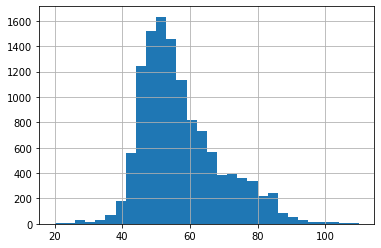

In [37]:
df_train['rougher.input.feed_size'].hist(bins=30, range =(20,110))

<AxesSubplot:>

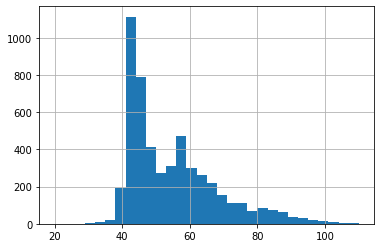

In [38]:
df_test['rougher.input.feed_size'].hist(bins=30, range =(20,110))

**Вывод 2.2**

Распределения имеют схожий вид. Статистические показатели (min, std, квантили) сопоставимы.

<font color='blue'><b>Комментарий ревьюера: </b></font> ✔️\
<font color='green'> Вывод верный!</font> \
<font color='darkorange'> В данном случае нужно использовать параметр "density=True" в методе ".hist()". Так бы нам удалось перейти от количества к доле.</font>

### 2.3. Исследование суммарной концентрации веществ на всех стадиях.

Исследуем суммарную концентрацию веществ на всех стадиях. Также продолжаем работать с тренировочной выборкой.

Для этого просумируем концентрации на каждом этапе.

In [39]:
df_sum_conc = df_train
#исходное сырье на входе
df_sum_conc['rougher.input.raw_sum'] = df_train['rougher.input.feed_ag']+df_train['rougher.input.feed_pb']+\
                                       df_train['rougher.input.feed_sol']+df_train['rougher.input.feed_au']

#суммурная концентраци
df_sum_conc['rougher.output.concentrate_sum'] = df_train['rougher.output.concentrate_ag']+df_train['rougher.output.concentrate_pb']+\
                                                df_train['rougher.output.concentrate_sol']+df_train['rougher.output.concentrate_au']

#суммурная концентрация веществ после первичной очистки
df_sum_conc['primary_cleaner.output.concentrate_sum'] = df_train['primary_cleaner.output.concentrate_ag']+df_train['primary_cleaner.output.concentrate_pb']+\
                                                df_train['primary_cleaner.output.concentrate_sol']+df_train['primary_cleaner.output.concentrate_au']

#суммурная концентрация веществ после всех этапов очистки
df_sum_conc['final.output.concentrate_sum'] = df_train['final.output.concentrate_ag']+df_train['final.output.concentrate_pb']+\
                                                df_train['final.output.concentrate_sol']+df_train['final.output.concentrate_au']

df_sum_conc[['rougher.input.raw_sum', 
             'rougher.output.concentrate_sum', 
             'primary_cleaner.output.concentrate_sum',
            'final.output.concentrate_sum']].head()

,rougher.input.raw_sum,rougher.output.concentrate_sum,primary_cleaner.output.concentrate_sum,final.output.concentrate_sum
date,,,,
2016-01-15 00:00:00,51.680034,66.424950,72.640924,63.644396
2016-01-15 01:00:00,50.659114,67.012710,72.543485,63.957723
2016-01-15 02:00:00,50.609929,66.103793,72.095042,64.311180
2016-01-15 03:00:00,51.061546,65.752751,59.957723,63.573449
2016-01-15 04:00:00,47.859163,65.908382,71.321010,64.004667


In [40]:
df_sum_conc[['rougher.input.raw_sum', 
             'rougher.output.concentrate_sum', 
             'primary_cleaner.output.concentrate_sum',
            'final.output.concentrate_sum']].describe()

,rougher.input.raw_sum,rougher.output.concentrate_sum,primary_cleaner.output.concentrate_sum,final.output.concentrate_sum
count,12245.000000,12245.000000,12245.000000,12245.000000
mean,56.702320,67.740021,60.454953,68.896651
std,6.465239,11.791937,9.697090,5.905578
min,0.040000,0.000000,0.000000,0.000000
25%,53.068005,65.290876,58.357309,67.753904
50%,56.869912,69.327464,61.839554,69.275904
75%,60.932924,73.525876,65.263295,71.110495
max,72.492216,87.273435,76.918076,80.210644


Рассмотрим гистограммы с суммарными концентрациями.

<AxesSubplot:>

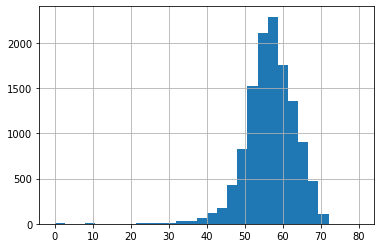

In [41]:
#распределение суммарной концентрации на входе
df_sum_conc['rougher.input.raw_sum'].hist(bins=30, range =(0,80))

<AxesSubplot:>

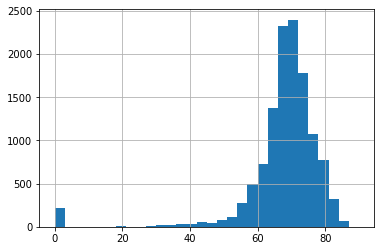

In [42]:
#распределение суммарной концентрации веществ после флотации
df_sum_conc['rougher.output.concentrate_sum'].hist(bins=30, range =(0,90))

<AxesSubplot:>

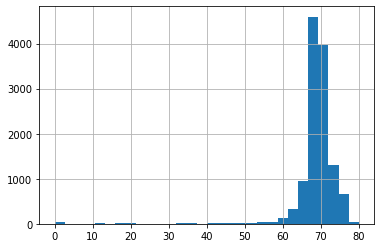

In [43]:
#распределение суммарной концентрации веществ после всех этапов очистки
df_sum_conc['final.output.concentrate_sum'].hist(bins=30, range =(0,80))

<AxesSubplot:>

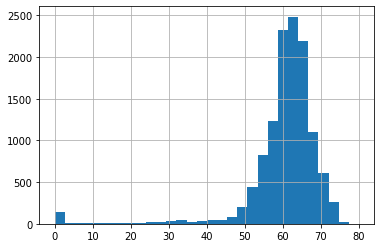

In [44]:
#распределение суммарной концентрации веществ после первичной очистки
df_sum_conc['primary_cleaner.output.concentrate_sum'].hist(bins=30, range =(0,80))

Из предоставленных графиков мы видим, что имеются нулевые значения суммарной концентрации на этапах очистки. Так как мы будем предсказывать значения востановления золота из руды, то нам необходимо избавиться от нулевых значений. 

У нас ключевые призкаки rougher.output.recovery и final.output.recovery. Eсли у нас доли элементов после очисток равны 0, то и сами целевые признаки, тоже будут равны 0.

Проверим нулевые значения.

In [45]:
df_train.loc[df_train.loc[:,'rougher.output.recovery'] == 0]['rougher.output.recovery'].count()

206

In [46]:
df_train.loc[df_train.loc[:,'final.output.recovery'] == 0]['final.output.recovery'].count()

31

Поэтому избавимся от 0 в целевых признаках.

In [47]:
df_train = df_train.loc[df_train.loc[:,'rougher.output.recovery'] > 0]
df_train = df_train.loc[df_train.loc[:,'final.output.recovery'] > 0]
df_train.head()

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level,rough_recov_calc,rougher.input.raw_sum,rougher.output.concentrate_sum,primary_cleaner.output.concentrate_sum,final.output.concentrate_sum
date,,,,,,,,,,,,,,,,,,,,,
2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,...,-498.310211,8.079666,-500.470978,14.151341,-605.841980,87.107763,51.680034,66.424950,72.640924,63.644396
2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629232,...,-500.169983,7.984757,-500.582168,13.998353,-599.787184,86.843261,50.659114,67.012710,72.543485,63.957723
2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,123.819808,...,-500.129135,8.013877,-500.517572,14.028663,-601.427363,86.842308,50.609929,66.103793,72.095042,64.311180
2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,122.270188,...,-499.201640,7.977324,-500.255908,14.005551,-599.996129,87.226430,51.061546,65.752751,59.957723,63.573449
2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,117.988169,...,-501.686727,7.894242,-500.356035,13.996647,-601.496691,86.688794,47.859163,65.908382,71.321010,64.004667


**Вывод 2.3.**

1. Суммарные концентрации распределены нормально.
2. Следует отметить что:
 - после флотации концентрация увеличивается;
 - далее после первичной очистки суммарная концентрация снижается;
 - при этом после вторичной очистки суммарная концентрация веществ снова увеличивается, но уже не так сильно, как на первом этапе. Это может быть связано с тем, что в ходе этапов очисток часть объема полезных элементов выходит вместе со шлаком.

## Модель

### 3.1. Подготовка функции для расчета итоговой sMAPE

Подготовим функцию для расчета итоговой sMAPE

In [48]:
def smape_count_total(t_1, p_1, t_2, p_2):
    #t_1 & t_2 - target
    #p_1 & p_2 - predicted value
    smape_rough = 100 * (1/len(t_1))*sum(abs(t_1-p_1)/((abs(t_1)+abs(p_1))/2))
    smape_final = 100 * (1/len(t_1))*sum(abs(t_2-p_2)/((abs(t_2)+abs(p_2))/2))
    smape_total = 0.25 * smape_rough + 0.75 * smape_final
    return smape_total

Подготовим функцию для расчета 1 smape

In [49]:
def smape_count(t_1, p_1):
    #t_1 - target
    #p_1 - predicted value
    smape = 100 * (1/len(t_1))*sum(abs(t_1-p_1)/((abs(t_1)+abs(p_1))/2))
    return smape

### 3.2. Подготовка моделей машинного обучения

Учитывая, что все рассмотернные признаки в датасетах имеют числовые значения и нам нужно будет предсказать числовое значение, то для данной задачи подойдут регрессионные методы машинного обучения.

Еще раз вернемся к обучающей и тестовой выборке, чтобы проверить, какие брать целевые признаки и какие будем предсказывать.

Важный нам показатель это эффективность востановления сырья после обработки. 
При этом следует отметить, что в полном датасете их 2:
- *rougher.output.recovery* - эф-ть востановления золота из руды после флотации
- *final.output.recovery* - эф-ть востановления золота из руды после очистки

Данные показатели показывают на сколько эффективно проходит процесс востановления. По ним мы и будем оценивать  симметричное среднее абсолютное процентное отклонение sMAPE.

Следует отметить, что в тестовой выборке отсутствуют данные признаки.
Поэтому нам сначала нужно предсказать *rougher.output.recovery*, а после *final.output.recovery*. Далее мы уже будем оценивать sMAPE.

На данном этапе будем предсказывать целевые признаки - эффективности востановления после флотации и финальной очискти. Возьмем тренировочную выборку и обозначим признаки. 

In [50]:
df_train_drop = df_train.drop(['final.output.concentrate_ag', 'final.output.concentrate_pb',
                               'final.output.concentrate_sol', 'final.output.concentrate_au',
                               'final.output.tail_ag', 'final.output.tail_pb',
                               'final.output.tail_sol', 'final.output.tail_au',
                               'primary_cleaner.output.concentrate_ag', 'primary_cleaner.output.concentrate_pb',
                               'primary_cleaner.output.concentrate_sol', 'primary_cleaner.output.concentrate_au',
                               'primary_cleaner.output.tail_ag', 'primary_cleaner.output.tail_pb',
                               'primary_cleaner.output.tail_sol', 'primary_cleaner.output.tail_au',
                               'rougher.calculation.sulfate_to_au_concentrate','rougher.calculation.floatbank10_sulfate_to_au_feed',
                               'rougher.calculation.floatbank11_sulfate_to_au_feed','rougher.calculation.au_pb_ratio',
                               'rougher.output.concentrate_ag','rougher.output.concentrate_pb',
                               'rougher.output.concentrate_sol', 'rougher.output.concentrate_au',
                               'rougher.output.tail_ag',  'rougher.output.tail_pb',
                               'rougher.output.tail_sol', 'rougher.output.tail_au',
                               'secondary_cleaner.output.tail_ag', 'secondary_cleaner.output.tail_pb',
                               'secondary_cleaner.output.tail_sol','secondary_cleaner.output.tail_au',
                               'rough_recov_calc', 'rougher.input.raw_sum', 'rougher.output.concentrate_sum',
                               'primary_cleaner.output.concentrate_sum', 'final.output.concentrate_sum'
                               ], axis=1)


not_in_rougher = [ 'primary_cleaner.input.sulfate', 'rougher.output.recovery', 'final.output.recovery',
                  'primary_cleaner.input.depressant', 'primary_cleaner.input.feed_size',
                  'primary_cleaner.input.xanthate','primary_cleaner.state.floatbank8_a_air',
                  'primary_cleaner.state.floatbank8_a_level','primary_cleaner.state.floatbank8_b_air',
                  'primary_cleaner.state.floatbank8_b_level','primary_cleaner.state.floatbank8_c_air',
                  'primary_cleaner.state.floatbank8_c_level','primary_cleaner.state.floatbank8_d_air',
                  'primary_cleaner.state.floatbank8_d_level','secondary_cleaner.state.floatbank2_a_air',
                  'secondary_cleaner.state.floatbank2_a_level','secondary_cleaner.state.floatbank2_b_air',
                  'secondary_cleaner.state.floatbank2_b_level','secondary_cleaner.state.floatbank3_a_air',
                  'secondary_cleaner.state.floatbank3_a_level','secondary_cleaner.state.floatbank3_b_air',
                  'secondary_cleaner.state.floatbank3_b_level','secondary_cleaner.state.floatbank4_a_air',
                  'secondary_cleaner.state.floatbank4_a_level','secondary_cleaner.state.floatbank4_b_air',
                  'secondary_cleaner.state.floatbank4_b_level','secondary_cleaner.state.floatbank5_a_air',
                  'secondary_cleaner.state.floatbank5_a_level','secondary_cleaner.state.floatbank5_b_air',
                  'secondary_cleaner.state.floatbank5_b_level','secondary_cleaner.state.floatbank6_a_air',
                  'secondary_cleaner.state.floatbank6_a_level']


features_train_rougher = df_train_drop.drop(not_in_rougher, axis = 1)
features_train_final = df_train_drop.drop(['rougher.output.recovery', 'final.output.recovery'], axis = 1)
target_train_rougher = df_train_drop['rougher.output.recovery']
target_train_final = df_train_drop['final.output.recovery']


smape_scorer = make_scorer(smape_count, greater_is_better=False)

Проверим с помощью метода GridSearchCV 3 модели, для предсказания эффективности востановления после флотации.

*- Линейная регрессия*

In [51]:
%%time
model_lin_regr_rougher = LinearRegression() #Востановление после флотации
model_lin_regr_final = LinearRegression() #Востановление после всех этапов очистки
parametrs_lin_regr = {'fit_intercept': ['True', 'False'],
                      'normalize': ['True', 'False'],
                      'n_jobs': [ -1, 1 ] }

grid_lin_rerg_rougher = GridSearchCV(model_lin_regr_rougher, parametrs_lin_regr,cv=5, scoring = smape_scorer)
grid_lin_rerg_final = GridSearchCV(model_lin_regr_final, parametrs_lin_regr,cv=5, scoring = smape_scorer)

grid_lin_rerg_rougher.fit(features_train_rougher, target_train_rougher)
grid_lin_rerg_final.fit(features_train_final, target_train_final)

print('Лучшие параметры rougher:', grid_lin_rerg_rougher.best_params_)
print('Лучшие параметры для final:', grid_lin_rerg_final.best_params_)
print('Лучший параметр sMAPE rougher:', grid_lin_rerg_rougher.best_score_)
print('Лучший параметр sMAPE final:', grid_lin_rerg_final.best_score_)

Лучшие параметры rougher: {'fit_intercept': 'True', 'n_jobs': -1, 'normalize': 'True'}
Лучшие параметры для final: {'fit_intercept': 'True', 'n_jobs': -1, 'normalize': 'True'}
Лучший параметр sMAPE rougher: -6.1105790664455055
Лучший параметр sMAPE final: -9.989888573466903
CPU times: user 9.4 s, sys: 12.5 s, total: 21.9 s
Wall time: 4.48 s


*- Дерево решений в регрессии*

In [52]:
%%time
model_tree_regr_rougher = DecisionTreeRegressor()
model_tree_regr_final = DecisionTreeRegressor()

parametrs_tree_regr = {'splitter': ['best', 'random'],
                       'max_depth': range (2, 10, 1)}

grid_tree_regr_rougher = GridSearchCV(model_tree_regr_rougher, parametrs_tree_regr, cv=5, scoring = smape_scorer)
grid_tree_regr_final = GridSearchCV(model_tree_regr_final, parametrs_tree_regr, cv=5, scoring = smape_scorer)

grid_tree_regr_rougher.fit(features_train_rougher, target_train_rougher)
grid_tree_regr_final.fit(features_train_final, target_train_final)

print('Лучшие параметры rougher:', grid_tree_regr_rougher.best_params_)
print('Лучшие параметры для final:', grid_tree_regr_final.best_params_)
print('Лучший параметр sMAPE rougher:', grid_tree_regr_rougher.best_score_)
print('Лучший параметр sMAPE final:', grid_tree_regr_final.best_score_)

Лучшие параметры rougher: {'max_depth': 4, 'splitter': 'random'}
Лучшие параметры для final: {'max_depth': 2, 'splitter': 'random'}
Лучший параметр sMAPE rougher: -6.129933843439489
Лучший параметр sMAPE final: -8.64595618445517
CPU times: user 11.6 s, sys: 555 ms, total: 12.2 s
Wall time: 11.5 s


*- случаный лес в регрессии*

In [53]:
%%time
model_ranfor_regr_rougher = RandomForestRegressor()
model_ranfor_regr_final = RandomForestRegressor()

parametrs_ranfor_regr = {'n_estimators': range (20, 100, 20)}

grid_ranfor_regr_rougher = GridSearchCV(model_ranfor_regr_rougher, parametrs_ranfor_regr,cv=5, 
                                        scoring = smape_scorer)
grid_ranfor_regr_final = GridSearchCV(model_ranfor_regr_final, parametrs_ranfor_regr,cv=5, 
                                      scoring = smape_scorer)

grid_ranfor_regr_rougher.fit(features_train_rougher, target_train_rougher)
grid_ranfor_regr_final.fit(features_train_final, target_train_final)

print('Лучшие параметры rougher:', grid_ranfor_regr_rougher.best_params_)
print('Лучшие параметры для final:', grid_ranfor_regr_rougher.best_params_)
print('Лучший параметр sMAPE rougher:', grid_ranfor_regr_rougher.best_score_)
print('Лучший параметр sMAPE final:', grid_ranfor_regr_rougher.best_score_)


Лучшие параметры rougher: {'n_estimators': 80}
Лучшие параметры для final: {'n_estimators': 80}
Лучший параметр sMAPE rougher: -6.365782695978092
Лучший параметр sMAPE final: -6.365782695978092
CPU times: user 8min 8s, sys: 654 ms, total: 8min 8s
Wall time: 8min 8s


По результатам GridSearchCV, лучшей моделью является случайный лес в регрессии

Теперь обучим на данной модели признаки.

In [54]:

%%time
#best_rf_params = grid.best_params_

model_ranfor_regr_rougher = RandomForestRegressor(**grid_ranfor_regr_rougher.best_params_)
model_ranfor_regr_final = RandomForestRegressor(**grid_ranfor_regr_final.best_params_)


model_ranfor_regr_rougher.fit(features_train_rougher, target_train_rougher)
model_ranfor_regr_final.fit(features_train_final, target_train_final)


pred_train_ranfor_regr_rougher = model_ranfor_regr_rougher.predict(features_train_rougher)
pred_train_ranfor_regr_final = model_ranfor_regr_final.predict(features_train_final)


print('sMAPE  итоговая для обучающей выборки', smape_count_total(target_train_rougher, pred_train_ranfor_regr_rougher,
                                           target_train_final, pred_train_ranfor_regr_final))



sMAPE  итоговая для обучающей выборки 1.6261275888175317
CPU times: user 38.2 s, sys: 49.3 ms, total: 38.2 s
Wall time: 38.2 s


### 3.3 Проверка модели на тестовой выборке и расчет sMAPE.

In [55]:
not_in_rougher_test = [ 'primary_cleaner.input.sulfate','primary_cleaner.input.depressant', 'primary_cleaner.input.feed_size',
                       'primary_cleaner.input.xanthate','primary_cleaner.state.floatbank8_a_air',
                       'primary_cleaner.state.floatbank8_a_level','primary_cleaner.state.floatbank8_b_air',
                       'primary_cleaner.state.floatbank8_b_level','primary_cleaner.state.floatbank8_c_air',
                       'primary_cleaner.state.floatbank8_c_level','primary_cleaner.state.floatbank8_d_air',
                       'primary_cleaner.state.floatbank8_d_level', 'secondary_cleaner.state.floatbank2_a_air',
                       'secondary_cleaner.state.floatbank2_a_level','secondary_cleaner.state.floatbank2_b_air',
                       'secondary_cleaner.state.floatbank2_b_level','secondary_cleaner.state.floatbank3_a_air',
                       'secondary_cleaner.state.floatbank3_a_level','secondary_cleaner.state.floatbank3_b_air',
                       'secondary_cleaner.state.floatbank3_b_level','secondary_cleaner.state.floatbank4_a_air',
                       'secondary_cleaner.state.floatbank4_a_level','secondary_cleaner.state.floatbank4_b_air',
                       'secondary_cleaner.state.floatbank4_b_level','secondary_cleaner.state.floatbank5_a_air',
                       'secondary_cleaner.state.floatbank5_a_level','secondary_cleaner.state.floatbank5_b_air',
                       'secondary_cleaner.state.floatbank5_b_level','secondary_cleaner.state.floatbank6_a_air',
                       'secondary_cleaner.state.floatbank6_a_level']

features_test_rougher = df_test.drop(not_in_rougher_test, axis = 1)
features_test_final = df_test

target_test_rougher = df_full['rougher.output.recovery'].loc[features_test_rougher.index]
target_test_final = df_full['final.output.recovery'].loc[features_test_final.index]

In [56]:
#target_test_rougher = df_full['rougher.output.recovery'].loc[features_test_rougher.index]
#target_test_final = df_full['final.output.recovery'].loc[features_test_final.index]

test_ranfor_regr_rougher = model_ranfor_regr_rougher.predict(features_test_rougher)
test_ranfor_regr_final = model_ranfor_regr_final.predict(features_test_final)

#введем DummyClassifier для проверки на адекватность.
d_model_rougrer = DummyRegressor(strategy='mean')
d_model_final = DummyRegressor(strategy='mean')

d_model_rougrer.fit(features_train_rougher, target_train_rougher)
d_model_final.fit(features_train_final, target_train_final)

pred_test_rougrer = d_model_rougrer.predict(features_test_rougher)
pred_test_final = d_model_final.predict(features_test_rougher)

sMAPE_test = smape_count_total(target_test_rougher, test_ranfor_regr_rougher, 
                         target_test_final, test_ranfor_regr_final)
sMAPE_d = smape_count_total(target_test_rougher, pred_test_rougrer, 
                         target_test_final, pred_test_final)

print('sMAPE_test', sMAPE_test)
print('sMAPE_d', sMAPE_d)

sMAPE_test 9.184776942388709
sMAPE_d 9.208949720540762


## Общий вывод

По результатам проведенного исследования видно, что

1) Доля золота на каждом этапе очистки становится выше, следовательно данная технология обработки эффективна.

2) Наилучше всего показала себя модель случайного леса в регрессии.

3) Итоговая sMAPE на тестовой выборке составила 9.184776942388709, что на 0,02 меньше чем в DummRegressor.